In [1]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./Final_Model_Dataset.csv ]]; then 
      wget https://raw.githubusercontent.com/ssadagop97/IST718-Fall2020/main/Final_Model_Dataset.csv
   # download the data file from github and save it in this colab environment instance
fi
ls Final_Model_Dataset.csv

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=fe13fcd0643ccd288718e8e8a96b0e78341adc76099213e3f89b6dbaaccb8b6b
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
Final_Model_Dataset.csv


--2020-11-29 13:51:15--  https://raw.githubusercontent.com/ssadagop97/IST718-Fall2020/main/Final_Model_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857901 (1.8M) [text/plain]
Saving to: ‘Final_Model_Dataset.csv’

     0K .......... .......... .......... .......... ..........  2% 4.09M 0s
    50K .......... .......... .......... .......... ..........  5% 10.3M 0s
   100K .......... .......... .......... .......... ..........  8% 5.01M 0s
   150K .......... .......... .......... .......... .......... 11% 16.3M 0s
   200K .......... .......... .......... .......... .......... 13% 7.02M 0s
   250K .......... .......... .......... .......... .......... 16% 34.8M 0s
   300K .......... .......... .......... .......... .......... 19% 25.5M 0s
   350K ....

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lower, col
MAX_MEMORY = "12g"
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)
genre_class_df = spark.read.format("csv").option("header", "true").load("Final_Model_Dataset.csv")

# Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn, Row 
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import feature, regression, evaluation, Pipeline

# Feature Extraction & Data Split


In [4]:
#Below features were selected using Random Forest Feature Importance
#imp_cols=['interest','spectral_contrast','num_tracks_in_album','chroma_stft','duration','num_listens_per_album','rmse','track_favorites','mfcc']
imp_cols=['spectral_rolloff', 'rmse', 'chroma_stft', 'spectral_centroid','spectral_contrast', 'spectral_bandwidth', 'zcr','track_favorites', 'num_listens_per_album', 'duration','num_listens_per_song']

for col_name in imp_cols:
    genre_class_df = genre_class_df.withColumn(col_name, col(col_name).cast('float'))

feature_engineering_pipe = Pipeline(stages=[
  feature.StringIndexer(inputCol='top_genres', handleInvalid='skip',outputCol = "Y_top_genre")
]).fit(genre_class_df)

genreclass_df=feature_engineering_pipe.transform(genre_class_df)

columns_to_drop = ['top_genres']
genreclass_df = genreclass_df.drop(*columns_to_drop)

training_df, validation_df,testing_df = genreclass_df.randomSplit([0.7, 0.1, 0.2], seed=0)

# Logistic Regression

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
VectorAssembler=VectorAssembler(inputCols=['spectral_rolloff', 'rmse', 'chroma_stft', 'spectral_centroid','spectral_contrast', 'spectral_bandwidth', 'zcr','track_favorites', 'num_listens_per_album', 'duration','num_listens_per_song'], outputCol = 'num_features')
StandardScaler=StandardScaler(withStd=True, inputCol='num_features', outputCol='std_features')
LogisticRegression = LogisticRegression(labelCol='Y_top_genre',featuresCol='std_features',maxIter=100, regParam=0.0, elasticNetParam=0.0, family="multinomial")

topgenre_lrbase_pipe = Pipeline(stages=[VectorAssembler,StandardScaler, LogisticRegression]).fit(training_df)

LRBaseSummary = topgenre_lrbase_pipe.stages[-1].summary

#Trained Base Model Evaluation
LR_baseTR_acc = LRBaseSummary.accuracy
LR_FPRBaseTr = LRBaseSummary.weightedFalsePositiveRate
LR_TPRBaseTr = LRBaseSummary.weightedTruePositiveRate
LR_fMeasureBaseTR = LRBaseSummary.weightedFMeasure()
LR_PrecisionBaseTR = LRBaseSummary.weightedPrecision
LR_RecallBaseTR = LRBaseSummary.weightedRecall
print("*********************Logistic Regression BASE Model Training Results*********************************")
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (LR_baseTR_acc, LR_FPRBaseTr, LR_TPRBaseTr, LR_fMeasureBaseTR, LR_PrecisionBaseTR, LR_RecallBaseTR))

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Y_top_genre", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Y_top_genre", rawPredictionCol="prediction", metricName='areaUnderROC')

predictionAndTarget = topgenre_lrbase_pipe.transform(testing_df).select("Y_top_genre", "prediction")

# Test BaseModel Evaluation
LR_baseTE_acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
LR_fMeasureBaseTE = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
LR_PrecisionBaseTE = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
LR_RecallBaseTE = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
#LR_Base_AUC = evaluator.evaluate(predictionAndTarget)

print("*********************Logistic Regression BASE Model Test Results*********************************")
print("Accuracy: %s\nf1: %s\nPrecision: %s\nRecall: %s"
      % (LR_baseTE_acc, LR_fMeasureBaseTE, LR_PrecisionBaseTE, LR_RecallBaseTE))
#print("Area Under Curve:", LR_Base_AUC)

*********************Logistic Regression BASE Model Training Results*********************************
Accuracy: 0.5013820290905795
FPR: 0.2496056620118069
TPR: 0.5013820290905795
F-measure: 0.4958713203618008
Precision: 0.4952896473427185
Recall: 0.5013820290905795
*********************Logistic Regression BASE Model Test Results*********************************
Accuracy: 0.5065057218999843
f1: 0.5016627231602454
Precision: 0.5008926167044715
Recall: 0.5065057218999843


In [6]:
enable_grid = False #Change to True to perform Grid Search
if enable_grid:
  from pyspark.ml.classification import LogisticRegression
  LogisticRegression_grid=LogisticRegression().\
  setLabelCol('Y_top_genre').\
  setFeaturesCol('std_features').\
  setRegParam(0.0).\
  setMaxIter(100).\
  setElasticNetParam(0.).setFamily('multinomial')
    
  top_genre_pipe_grid = Pipeline(stages=[VectorAssembler,StandardScaler, LogisticRegression_grid])
  grid = ParamGridBuilder().\
  addGrid(LogisticRegression_grid.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]).\
  addGrid(LogisticRegression_grid.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]).\
  build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = top_genre_pipe_grid.fit(training_df, grid[j])
      all_models.append(model)

  accuracies = [m.\
  transform(validation_df).\
  select(fn.avg(fn.expr('float(Y_top_genre = prediction)')).alias('accuracy')).\
  first().\
  accuracy for m in all_models]

  import numpy as np

  best_model_idx = np.argmax(accuracies)
  print("best model index =", best_model_idx)
  print("Best Model",grid[best_model_idx])
  
  best_model = all_models[best_model_idx]
  best_model.\
  transform(testing_df).\
  select(fn.avg(fn.expr('float(Y_top_genre = prediction)')).alias('accuracy')).\
  show()
  pass

In [7]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import feature, regression, evaluation, Pipeline

#Hyperparameters from Cross Validation
alpha = 0.1
lambda_par = 0.01
VectorAssembler=VectorAssembler(inputCols=['spectral_rolloff', 'rmse', 'chroma_stft', 'spectral_centroid','spectral_contrast', 'spectral_bandwidth', 'zcr','track_favorites', 'num_listens_per_album', 'duration','num_listens_per_song'], outputCol = 'num_features')
StandardScaler=StandardScaler(withStd=True, inputCol='num_features', outputCol='std_features')
LogisticRegression = LogisticRegression(labelCol='Y_top_genre',featuresCol='std_features',maxIter=100, regParam=lambda_par, elasticNetParam=lambda_par, family="multinomial")

topgenre_lrfinal_pipe = Pipeline(stages=[VectorAssembler,StandardScaler, LogisticRegression]).fit(training_df)

LRFinalSummary = topgenre_lrfinal_pipe.stages[-1].summary

#Trained Final Model Evaluation
LRTR_accuracy = LRFinalSummary.accuracy
LRTR_FPR = LRFinalSummary.weightedFalsePositiveRate
LRTR_TPR = LRFinalSummary.weightedTruePositiveRate
LRTR_FMeasure = LRFinalSummary.weightedFMeasure()
LRTR_Precision = LRFinalSummary.weightedPrecision
LRTR_Recall = LRFinalSummary.weightedRecall
print("*********************Logistic Regression Final Model Training Results*********************************")
print("Training Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (LRTR_accuracy, LRTR_FPR, LRTR_TPR, LRTR_FMeasure, LRTR_Precision, LRTR_Recall))

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Y_top_genre", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Y_top_genre", rawPredictionCol="prediction", metricName='areaUnderROC')

predictionAndTarget = topgenre_lrfinal_pipe.transform(testing_df).select("Y_top_genre", "prediction")

# Test Final Model Evaluation
LRTE_accuracy = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
LRTE_FMeasure = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
LRTE_Precision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
LRTE_Recall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
#LR_Final_AUC = evaluator.evaluate(predictionAndTarget)
print("*********************Logistic Regression Final Model Test Results*********************************")
print("Test Accuracy: %s\nf1: %s\nPrecision: %s\nRecall: %s"
      % (LRTE_accuracy, LRTE_FMeasure, LRTE_Precision, LRTE_Recall))
#print("Area Under Curve:", LR_Final_AUC)

*********************Logistic Regression Final Model Training Results*********************************
Training Accuracy: 0.5009742172277856
FPR: 0.24984800576218513
TPR: 0.5009742172277856
F-measure: 0.49508724914008095
Precision: 0.49463105992872936
Recall: 0.5009742172277856
*********************Logistic Regression Final Model Test Results*********************************
Test Accuracy: 0.5071327794325129
f1: 0.5021853852683762
Precision: 0.5015849089419002
Recall: 0.5071327794325129


# Naive Bayes

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import feature, regression, evaluation, Pipeline

VectorAssembler=VectorAssembler(inputCols=['spectral_rolloff', 'rmse', 'chroma_stft', 'spectral_centroid','spectral_contrast', 'spectral_bandwidth', 'zcr','track_favorites', 'num_listens_per_album', 'duration','num_listens_per_song'], outputCol = 'num_features')
StandardScaler=StandardScaler(withStd=False, inputCol='num_features', outputCol='std_features')
NBBasemodel=NaiveBayes().setLabelCol('Y_top_genre').setFeaturesCol('std_features')
topgenre_nbfinal_pipe = Pipeline(stages=[VectorAssembler,StandardScaler, NBBasemodel]).fit(training_df)

#NBFinalSummary = topgenre_nbfinal_pipe.stages[-1].summary
#
##Trained Final Model Evaluation
#NBTR_accuracy = NBFinalSummary.accuracy
#NBTR_FPR = NBFinalSummary.weightedFalsePositiveRate
#NBTR_TPR = NBFinalSummary.weightedTruePositiveRate
#NBTR_FMeasure = NBFinalSummary.weightedFMeasure()
#NBTR_Precision = NBFinalSummary.weightedPrecision
#NBTR_Recall = NBFinalSummary.weightedRecall
#print("*********************Naive Bayes Final Model Training Results*********************************")
#print("Training Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
#      % (NBTR_accuracy, NBTR_FPR, NBTR_TPR, NBTR_FMeasure, NBTR_Precision, NBTR_Recall))
#
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Y_top_genre", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Y_top_genre", rawPredictionCol="prediction", metricName='areaUnderROC')

predictionAndTarget = topgenre_nbfinal_pipe.transform(testing_df).select("Y_top_genre", "prediction")

# Test Final Model Evaluation
NBTE_accuracy = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
NBTE_FMeasure = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
NBTE_Precision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
NBTE_Recall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
#NB_Final_AUC = evaluator.evaluate(predictionAndTarget)
print("*********************Naive Bayes Final Model Test Results*********************************")
print("Test Accuracy: %s\nf1: %s\nPrecision: %s\nRecall: %s"
      % (NBTE_accuracy, NBTE_FMeasure, NBTE_Precision, NBTE_Recall))
#print("Area Under Curve:", NB_Final_AUC)

*********************Naive Bayes Final Model Test Results*********************************
Test Accuracy: 0.4847154726446151
f1: 0.47453797349937316
Precision: 0.4767692516804818
Recall: 0.4847154726446151


# Neural Networks

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

VectorAssembler=VectorAssembler(inputCols=['spectral_rolloff', 'rmse', 'chroma_stft', 'spectral_centroid','spectral_contrast', 'spectral_bandwidth', 'zcr','track_favorites', 'num_listens_per_album', 'duration','num_listens_per_song'], outputCol = 'num_features')
StandardScaler=StandardScaler(withStd=True, inputCol='num_features', outputCol='std_features')

#Defined layers based on the input features
#First layer consists of 11 neurons as we have 11 features
#Final layer has 3 neurons as we have 3 classes for classification
layers = [11,22,9,3]

# create the trainer and set its parameters
NeuralBaseModel = MultilayerPerceptronClassifier(labelCol="Y_top_genre", featuresCol="std_features", maxIter=100, layers=layers, blockSize=32, seed=10 ,tol=0.00000001,stepSize=0.1)
topgenre_NNbase_pipe = Pipeline(stages=[VectorAssembler, StandardScaler, NeuralBaseModel]).fit(training_df)

#NNBaseSummary = topgenre_NNbase_pipe.stages[-1].summary
#
##Trained Base Model Evaluation
#NNBaseTR_accuracy = NNBaseSummary.accuracy
#NNBaseTR_FPR = NNBaseSummary.weightedFalsePositiveRate
#NNBaseTR_TPR = NNBaseSummary.weightedTruePositiveRate
#NNBaseTR_FMeasure = NNBaseSummary.weightedFMeasure()
#NNBaseTR_Precision = NNBaseSummary.weightedPrecision
#NNBaseTR_Recall = NNBaseSummary.weightedRecall
#print("*********************Training Results*********************************")
#print("Training Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
#      % (NNBaseTR_accuracy, NNBaseTR_FPR, NNBaseTR_TPR, NNBaseTR_FMeasure, NNBaseTR_Precision, NNBaseTR_Recall))

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Y_top_genre", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Y_top_genre", rawPredictionCol="prediction", metricName='areaUnderROC')

predictionAndTarget = topgenre_NNbase_pipe.transform(testing_df).select("Y_top_genre", "prediction")

# Test Base Model Evaluation
NNBaseTE_accuracy = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
NNBaseTE_FMeasure = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
NNBaseTE_Precision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
NNBaseTE_Recall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
#NN_Base_AUC = evaluator.evaluate(predictionAndTarget)
print("*********************Neural Networks Base Model Test Results*********************************")
print("Test Accuracy: %s\nf1: %s\nPrecision: %s\nRecall: %s"
      % (NNBaseTE_accuracy, NNBaseTE_FMeasure, NNBaseTE_Precision, NNBaseTE_Recall))
#print("Area Under Curve:", NN_Base_AUC)

*********************Neural Networks Base Model Test Results*********************************
Test Accuracy: 0.5292365574541464
f1: 0.527265823838639
Precision: 0.5275082733892166
Recall: 0.5292365574541464


In [10]:
enable_grid = False #Change to True to perform Grid Search which will look for 5*4*5*5 = 500 models
if enable_grid:
  from pyspark.ml.classification import MultilayerPerceptronClassifier
  #Layers combinations
  l1 = [11,22,9,3]
  l2 = [11,9,3]
  l3 = [11,9,6,3]
  l4 = [11,3,3]
  l5 = [11,3]
  NeuralBaseModel = MultilayerPerceptronClassifier(labelCol="Y_top_genre", featuresCol="std_features", maxIter=100, layers=l1, blockSize=32, seed=10 ,tol=0.00000001,stepSize=0.1)
  top_genre_pipe_grid = Pipeline(stages=[VectorAssembler, StandardScaler, NeuralBaseModel])
  grid = ParamGridBuilder().\
  addGrid(NeuralBaseModel.blockSize, [16, 32, 64, 128,256]).\
  addGrid(NeuralBaseModel.tol, [0.000001,0.0000001,0.00000001,0.000000001]).\
  addGrid(NeuralBaseModel.stepSize, [0.001, 0.01, 0.1, 0.2, 0.3]).\
  addGrid(NeuralBaseModel.layers, [l1,l2,l3,l4,l5]).\
  build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = top_genre_pipe_grid.fit(training_df, grid[j])
      all_models.append(model)

  accuracies = [m.\
  transform(validation_df).\
  select(fn.avg(fn.expr('float(Y_top_genre = prediction)')).alias('accuracy')).\
  first().\
  accuracy for m in all_models]

  import numpy as np

  best_model_idx = np.argmax(accuracies)
  print("best model index =", best_model_idx)
  print("Best Model",grid[best_model_idx])
  
  best_model = all_models[best_model_idx]
  best_model.\
  transform(testing_df).\
  select(fn.avg(fn.expr('float(Y_top_genre = prediction)')).alias('accuracy')).\
  show()
  pass

In [11]:
#Final layer has 3 neurons as we have 3 classes for classification
#Below parameters have been hardcoded from GridSearch results
#The optimizer & activation function could not be optimized as Spark has default values for optimizer (gd or l-bfgs) and sigmoid & softmax activation functions for intermediate and output layers respectively
#Probably because of this reason, Neural Network is not the best performing model
layers = [11,22,9,3]
tolerance = 0.001
learningrate = 0.000001
blocksize = 32

# create the trainer and set its parameters
NeuralBaseModel = MultilayerPerceptronClassifier(labelCol="Y_top_genre", featuresCol="std_features", maxIter=100, layers=layers, blockSize=blocksize, seed=10 ,tol=tolerance,stepSize=learningrate)
topgenre_NNfinal_pipe = Pipeline(stages=[VectorAssembler, StandardScaler, NeuralBaseModel]).fit(training_df)

#NNFinalSummary = topgenre_NNfinal_pipe.stages[-1].summary
#
##Trained Final Model Evaluation
#NNFinalTR_accuracy = NNFinalSummary.accuracy
#NNFinalTR_FPR = NNFinalSummary.weightedFalsePositiveRate
#NNFinalTR_TPR = NNFinalSummary.weightedTruePositiveRate
#NNFinalTR_FMeasure = NNFinalSummary.weightedFMeasure()
#NNFinalTR_Precision = NNFinalSummary.weightedPrecision
#NNFinalTR_Recall = NNFinalSummary.weightedRecall
#print("*********************Training Results*********************************")
#print("Training Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
#      % (NNFinalTR_accuracy, NNFinalTR_FPR, NNFinalTR_TPR, NNFinalTR_FMeasure, NNFinalTR_Precision, NNFinalTR_Recall))

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Y_top_genre", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Y_top_genre", rawPredictionCol="prediction", metricName='areaUnderROC')

predictionAndTarget = topgenre_NNfinal_pipe.transform(testing_df).select("Y_top_genre", "prediction")

# Test Final Model Evaluation
NNFinalTE_accuracy = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
NNFinalTE_FMeasure = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
NNFinalTE_Precision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
NNFinalTE_Recall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
#NN_Final_AUC = evaluator.evaluate(predictionAndTarget)
print("*********************Neural Networks Final Model Test Results*********************************")
print("Test Accuracy: %s\nf1: %s\nPrecision: %s\nRecall: %s"
      % (NNFinalTE_accuracy, NNFinalTE_FMeasure, NNFinalTE_Precision, NNFinalTE_Recall))
#print("Area Under Curve:", NN_Final_AUC)

*********************Neural Networks Final Model Test Results*********************************
Test Accuracy: 0.5292365574541464
f1: 0.527265823838639
Precision: 0.5275082733892166
Recall: 0.5292365574541464


# Random Forest

In [12]:
from pyspark.ml.feature import VectorAssembler

VectorAssembler=VectorAssembler(inputCols=['spectral_rolloff', 'rmse', 'chroma_stft', 'spectral_centroid','spectral_contrast', 'spectral_bandwidth', 'zcr','track_favorites', 'num_listens_per_album', 'duration','num_listens_per_song'], outputCol = 'num_features')
RFBasemodel = RandomForestClassifier(labelCol="Y_top_genre", \
                            featuresCol="num_features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

topgenre_RFbase_pipe = Pipeline(stages=[VectorAssembler, RFBasemodel]).fit(training_df)

#RFBaseSummary = topgenre_RFbase_pipe.stages[-1].summary
#
##Trained Base Model Evaluation
#RFBaseTR_accuracy = RFBaseSummary.accuracy
#RFBaseTR_FPR = RFBaseSummary.weightedFalsePositiveRate
#RFBaseTR_TPR = RFBaseSummary.weightedTruePositiveRate
#RFBaseTR_FMeasure = RFBaseSummary.weightedFMeasure()
#RFBaseTR_Precision = RFBaseSummary.weightedPrecision
#RFBaseTR_Recall = RFBaseSummary.weightedRecall
#print("*********************Training Results*********************************")
#print("Training Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
#      % (RFBaseTR_accuracy, RFBaseTR_FPR, RFBaseTR_TPR, RFBaseTR_FMeasure, RFBaseTR_Precision, RFBaseTR_Recall))

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Y_top_genre", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Y_top_genre", rawPredictionCol="prediction", metricName='areaUnderROC')
predictionAndTarget = topgenre_RFbase_pipe.transform(testing_df).select("Y_top_genre", "prediction")

# Test Base Model Evaluation
RFBaseTE_accuracy = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
RFBaseTE_FMeasure = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
RFBaseTE_Precision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
RFBaseTE_Recall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
#RF_Base_AUC = evaluator.evaluate(predictionAndTarget)
print("*********************Random Forest Base Model Test Results*********************************")
print("Test Accuracy: %s\nf1: %s\nPrecision: %s\nRecall: %s"
      % (RFBaseTE_accuracy, RFBaseTE_FMeasure, RFBaseTE_Precision, RFBaseTE_Recall))
#print("Area Under Curve:", RF_Base_AUC)

*********************Random Forest Base Model Test Results*********************************
Test Accuracy: 0.5112086533939489
f1: 0.505007415623297
Precision: 0.508204659444156
Recall: 0.5112086533939489


In [13]:
enable_grid = False #Change to True to perform Grid Search
if enable_grid:
  from pyspark.ml.classification import RandomForestClassifier
  RFBasemodel_grid=RandomForestClassifier().\
  setLabelCol('Y_top_genre').\
  setFeaturesCol('num_features').\
  setNumTrees(100).\
  setMaxDepth(4).\
  setMaxBins(32)
    
  top_genre_pipe_grid = Pipeline(stages=[VectorAssembler, RFBasemodel_grid])
  grid = ParamGridBuilder().\
  addGrid(RFBasemodel_grid.numTrees, [10,15,20,25]).\
  addGrid(RFBasemodel_grid.maxDepth, [5,10,15]).\
  addGrid(RFBasemodel_grid.maxBins, [4,6,8,10]).\
  build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = top_genre_pipe_grid.fit(training_df, grid[j])
      all_models.append(model)

  accuracies = [m.\
  transform(validation_df).\
  select(fn.avg(fn.expr('float(Y_top_genre = prediction)')).alias('accuracy')).\
  first().\
  accuracy for m in all_models]

  import numpy as np

  best_model_idx = np.argmax(accuracies)
  print("best model index =", best_model_idx)
  print("Best Model",grid[best_model_idx])
  
  best_model = all_models[best_model_idx]
  best_model.\
  transform(testing_df).\
  select(fn.avg(fn.expr('float(Y_top_genre = prediction)')).alias('accuracy')).\
  show()
  pass

In [14]:
#Tuned Hyperparameters
trees=20
depth=15
bins=6

from pyspark.ml.feature import VectorAssembler

VectorAssembler=VectorAssembler(inputCols=['spectral_rolloff', 'rmse', 'chroma_stft', 'spectral_centroid','spectral_contrast', 'spectral_bandwidth', 'zcr','track_favorites', 'num_listens_per_album', 'duration','num_listens_per_song'], outputCol = 'num_features')
RFBasemodel = RandomForestClassifier(labelCol="Y_top_genre", \
                            featuresCol="num_features", \
                            numTrees = trees, \
                            maxDepth = depth, \
                            maxBins = bins)

topgenre_RFFinal_pipe = Pipeline(stages=[VectorAssembler, RFBasemodel]).fit(training_df)

#RFBaseSummary = topgenre_RFFinal_pipe.stages[-1].summary
#
##Trained Final Model Evaluation
#RFFinalTR_accuracy = RFBaseSummary.accuracy
#RFFinalTR_FPR = RFBaseSummary.weightedFalsePositiveRate
#RFFinalTR_TPR = RFBaseSummary.weightedTruePositiveRate
#RFFinalTR_FMeasure = RFBaseSummary.weightedFMeasure()
#RFFinalTR_Precision = RFBaseSummary.weightedPrecision
#RFFinalTR_Recall = RFBaseSummary.weightedRecall
#print("*********************Training Results*********************************")
#print("Training Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
#      % (RFFinalTR_accuracy, RFFinalTR_FPR, RFFinalTR_TPR, RFFinalTR_FMeasure, RFFinalTR_Precision, RFFinalTR_Recall))

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Y_top_genre", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Y_top_genre", rawPredictionCol="prediction", metricName='areaUnderROC')
predictionAndTarget = topgenre_RFFinal_pipe.transform(testing_df).select("Y_top_genre", "prediction")

# Test Final Model Evaluation
RFFinalTE_accuracy = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
RFFinalTE_FMeasure = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
RFFinalTE_Precision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
RFFinalTE_Recall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
#RF_Final_AUC = evaluator.evaluate(predictionAndTarget)
print("*********************Random Forest Final Model Test Results*********************************")
print("Test Accuracy: %s\nf1: %s\nPrecision: %s\nRecall: %s"
      % (RFFinalTE_accuracy, RFFinalTE_FMeasure, RFFinalTE_Precision, RFFinalTE_Recall))
#print("Area Under Curve:", RF_Final_AUC)

*********************Random Forest Final Model Test Results*********************************
Test Accuracy: 0.5706223546010346
f1: 0.5701214214442426
Precision: 0.57193813137638
Recall: 0.5706223546010347


# Model Comparison

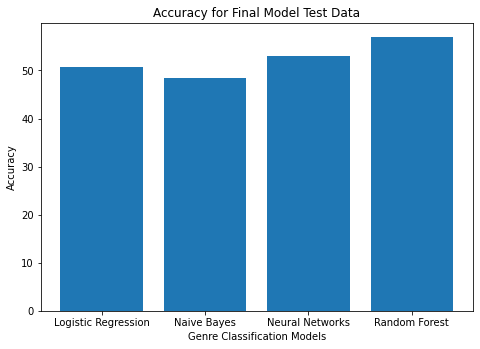

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Logistic Regression', 'Naive Bayes', 'Neural Networks', 'Random Forest']
AUC = [LRTE_accuracy*100,NBTE_accuracy*100,NNFinalTE_accuracy*100,RFFinalTE_accuracy*100]
plt.title('Accuracy for Final Model Test Data')
plt.xlabel('Genre Classification Models')
plt.ylabel('Accuracy')
ax.bar(models,AUC)
plt.show()

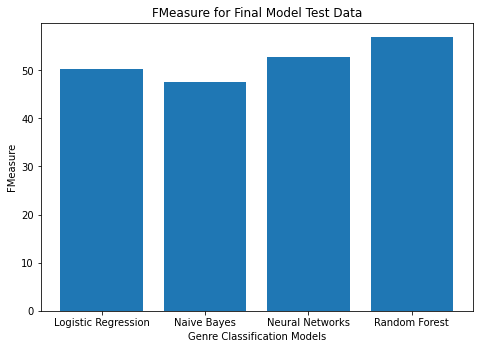

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Logistic Regression', 'Naive Bayes', 'Neural Networks', 'Random Forest']
FMea = [LRTE_FMeasure*100,NBTE_FMeasure*100,NNFinalTE_FMeasure*100,RFFinalTE_FMeasure*100]
plt.title('FMeasure for Final Model Test Data')
plt.xlabel('Genre Classification Models')
plt.ylabel('FMeasure')
ax.bar(models,FMea)
plt.show()